In [210]:
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree, svm
from sklearn.metrics import accuracy_score, f1_score, recall_score, balanced_accuracy_score, precision_score
import seaborn as sns



In [158]:
train = pd.read_csv('data/train.sample.csv')
test = pd.read_csv('data/test.csv')

train.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,617183,78554,102913,79.69,20,23822,48,6315,28-08-1968,Self employed,...,0,0,10787,0,2,1,1yrs 6mon,4yrs 0mon,0,1
1,515702,44349,61300,75.04,68,16873,45,862,02-06-1976,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,0
2,466872,54259,63767,87.82,160,24291,86,40,13-10-1976,Self employed,...,0,0,13019,0,0,0,1yrs 10mon,10yrs 10mon,0,0
3,632384,41994,69775,61.05,36,24047,86,6732,09-10-1983,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
4,461426,43599,62137,73.23,13,15884,86,4619,18-11-1984,Self employed,...,0,0,339591,0,2,0,1yrs 0mon,2yrs 2mon,0,0


In [159]:
print(train.dtypes)
print(train.describe())
print(train.info())

UNIQUEID                                 int64
DISBURSED_AMOUNT                         int64
ASSET_COST                               int64
LTV                                    float64
BRANCH_ID                                int64
SUPPLIER_ID                              int64
MANUFACTURER_ID                          int64
CURRENT_PINCODE_ID                       int64
DATE_OF_BIRTH                           object
EMPLOYMENT_TYPE                         object
DISBURSAL_DATE                          object
STATE_ID                                 int64
EMPLOYEE_CODE_ID                         int64
MOBILENO_AVL_FLAG                        int64
AADHAR_FLAG                              int64
PAN_FLAG                                 int64
VOTERID_FLAG                             int64
DRIVING_FLAG                             int64
PASSPORT_FLAG                            int64
PERFORM_CNS_SCORE                        int64
PERFORM_CNS_SCORE_DESCRIPTION           object
PRI_NO_OF_ACC

Special columns analysis

In [160]:
temp_counts = train['EMPLOYMENT_TYPE'].value_counts(dropna=False)
print(temp_counts)

temp_counts = train['AVERAGE_ACCT_AGE'].value_counts(dropna=False)
print(temp_counts)

temp_counts = train['CREDIT_HISTORY_LENGTH'].value_counts(dropna=False)
print(temp_counts)

EMPLOYMENT_TYPE
Self employed    12849
Salaried          9672
NaN                794
Name: count, dtype: int64
AVERAGE_ACCT_AGE
0yrs 0mon      11983
0yrs 6mon        611
0yrs 11mon       537
0yrs 9mon        527
0yrs 7mon        522
               ...  
8yrs 9mon          1
10yrs 3mon         1
11yrs 2mon         1
13yrs 10mon        1
11yrs 8mon         1
Name: count, Length: 137, dtype: int64
CREDIT_HISTORY_LENGTH
0yrs 0mon      11953
0yrs 6mon        498
2yrs 1mon        459
0yrs 7mon        404
2yrs 0mon        372
               ...  
22yrs 11mon        1
20yrs 1mon         1
13yrs 6mon         1
15yrs 10mon        1
17yrs 11mon        1
Name: count, Length: 209, dtype: int64


Data transformation

In [161]:
# FUNCTIONS

def convert_to_months(duration):
    if pd.isnull(duration):
        return None  # Handle missing values if any
    parts = duration.split()
    years = int(parts[0].replace('yrs', ''))
    months = int(parts[1].replace('mon', ''))
    return years * 12 + months

In [162]:
transformed_train = train.copy()
transformed_test = test.copy()

# DATE_OF_BIRTH -> MILIS
transformed_train['DATE_OF_BIRTH'] = pd.to_datetime(transformed_train['DATE_OF_BIRTH'], format='%d-%m-%Y')
transformed_train['DATE_OF_BIRTH'] = transformed_train['DATE_OF_BIRTH'].view('int64')
transformed_test['DATE_OF_BIRTH'] = pd.to_datetime(transformed_test['DATE_OF_BIRTH'], format='%d-%m-%Y')
transformed_test['DATE_OF_BIRTH'] = transformed_test['DATE_OF_BIRTH'].view('int64')
# DISBURSAL -> MILIS
transformed_train['DISBURSAL_DATE'] = pd.to_datetime(transformed_train['DISBURSAL_DATE'], format='%d-%m-%Y')
transformed_train['DISBURSAL_DATE'] = transformed_train['DISBURSAL_DATE'].view('int64')
transformed_test['DISBURSAL_DATE'] = pd.to_datetime(transformed_test['DISBURSAL_DATE'], format='%d-%m-%Y')
transformed_test['DISBURSAL_DATE'] = transformed_test['DISBURSAL_DATE'].view('int64')
# EMPLOYMENT_TYPE -> 1,2,3
transformed_train['EMPLOYMENT_TYPE'] = transformed_train['EMPLOYMENT_TYPE'].fillna('Unknown')
transformed_test['EMPLOYMENT_TYPE'] = transformed_test['EMPLOYMENT_TYPE'].fillna('Unknown')
employment_type_mapping = {'Salaried': 0, 'Self employed': 1, 'Unknown': 2}
transformed_train['EMPLOYMENT_TYPE'] = transformed_train['EMPLOYMENT_TYPE'].map(employment_type_mapping)
transformed_test['EMPLOYMENT_TYPE'] = transformed_test['EMPLOYMENT_TYPE'].map(employment_type_mapping)
# PERFORM_CNS_SCORE_DESCRIPTION -> CATEGORICAL
unique_descriptions_train = transformed_train['PERFORM_CNS_SCORE_DESCRIPTION'].unique()
unique_descriptions_test =  transformed_test['PERFORM_CNS_SCORE_DESCRIPTION'].unique()
unique_descriptions = pd.Series(list(unique_descriptions_train) + list(unique_descriptions_test)).unique()
description_mapping = {description: idx + 1 for idx, description in enumerate(unique_descriptions)}
transformed_train['PERFORM_CNS_SCORE_DESCRIPTION'] = transformed_train['PERFORM_CNS_SCORE_DESCRIPTION'].map(description_mapping)
transformed_test['PERFORM_CNS_SCORE_DESCRIPTION'] = transformed_test['PERFORM_CNS_SCORE_DESCRIPTION'].map(description_mapping)

# AVERAGE_ACCT_AGE -> MONTHS
transformed_train['AVERAGE_ACCT_AGE'] = transformed_train['AVERAGE_ACCT_AGE'].map(convert_to_months)
transformed_test['AVERAGE_ACCT_AGE'] = transformed_test['AVERAGE_ACCT_AGE'].map(convert_to_months)
# CREDIT_HISTORY_LENGTH -> MONTHS
transformed_train['CREDIT_HISTORY_LENGTH'] = transformed_train['CREDIT_HISTORY_LENGTH'].map(convert_to_months)
transformed_test['CREDIT_HISTORY_LENGTH'] = transformed_test['CREDIT_HISTORY_LENGTH'].map(convert_to_months)


print(transformed_train[['DATE_OF_BIRTH', 'DISBURSAL_DATE', 'EMPLOYMENT_TYPE', 'PERFORM_CNS_SCORE_DESCRIPTION', 'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH']].tail())


/var/folders/zh/8xn0j_xd66v8tnm0hjzkw5940000gn/T/ipykernel_15770/765574959.py:6: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  transformed_train['DATE_OF_BIRTH'] = transformed_train['DATE_OF_BIRTH'].view('int64')
/var/folders/zh/8xn0j_xd66v8tnm0hjzkw5940000gn/T/ipykernel_15770/765574959.py:8: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  transformed_test['DATE_OF_BIRTH'] = transformed_test['DATE_OF_BIRTH'].view('int64')
/var/folders/zh/8xn0j_xd66v8tnm0hjzkw5940000gn/T/ipykernel_15770/765574959.py:11: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  transformed_train['DISBURSAL_DATE'] = transformed_train['DISBURSAL_DATE'].view('int64')
/var/folders/zh/8xn0j_xd66v8tnm0hjzkw5940000gn/T/ipykernel_15770/765574959.py:13: Fu

            DATE_OF_BIRTH       DISBURSAL_DATE  EMPLOYMENT_TYPE  \
23310  788313600000000000  1537747200000000000                1   
23311   93657600000000000  1535068800000000000                2   
23312 -126230400000000000  1534809600000000000                0   
23313  293760000000000000  1540771200000000000                1   
23314  504921600000000000  1536796800000000000                1   

       PERFORM_CNS_SCORE_DESCRIPTION  AVERAGE_ACCT_AGE  CREDIT_HISTORY_LENGTH  
23310                              9                 6                     14  
23311                              2                 0                      0  
23312                              6                 6                      6  
23313                              6                 7                      7  
23314                              2                 0                      0  


In [163]:
# profile = ProfileReport(transformed_train, title="EDA Report", explorative=True)
# profile.to_notebook_iframe()

Data clean

In [164]:
# FUNCTIONS

def remove_outliers_quantile(df, column, bounding_factor=1.5):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - bounding_factor * IQR
    upper_bound = Q3 + bounding_factor * IQR

    # Filter the DataFrame to remove outliers
    original_row_count = len(df)
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    new_row_count = len(filtered_df)

    # Calculate the number of rows dropped
    rows_dropped = original_row_count - new_row_count

    # Display the results
    print(f"Original number of rows: {original_row_count}")
    print(f"Number of rows after removing outliers: {new_row_count}")
    print(f"Number of rows dropped: {rows_dropped}")


def remove_outliers_threshold(df, column, threshold):
    #Filter the DataFrame to remove outliers
    original_row_count = len(df)
    filtered_df = df[df[column] <= threshold]
    new_row_count = len(filtered_df)

    # Calculate the number of rows dropped
    rows_dropped = original_row_count - new_row_count

    # Display the results
    print(f"Original number of rows: {original_row_count}")
    print(f"Number of rows after removing outliers: {new_row_count}")
    print(f"Number of rows dropped: {rows_dropped}")


In [165]:
cleaned_train = transformed_train.copy()
cleaned_test = transformed_test.copy()

# Removing extremely high loans
remove_outliers_threshold(cleaned_train, 'DISBURSED_AMOUNT', 300000)


# UNIQUEID is unique for every row,  and MOBILENO_AVL_FLAG is constant
constant_columns = [col for col in cleaned_train.columns if cleaned_train[col].nunique() == 1]
unique_columns = [col for col in cleaned_train.columns if cleaned_train[col].nunique() == len(cleaned_train)]
columns_to_drop = unique_columns + constant_columns
cleaned_train = cleaned_train.drop(columns=columns_to_drop)
cleaned_test = cleaned_test.drop(columns=columns_to_drop)

print(f"Columns dropped: {columns_to_drop}")



Original number of rows: 23315
Number of rows after removing outliers: 23313
Number of rows dropped: 2
Columns dropped: ['UNIQUEID', 'MOBILENO_AVL_FLAG']


FINAL DATA

In [166]:
final_train = cleaned_train.copy()
final_test = cleaned_test.copy()
scaler = StandardScaler()


X_final_train = scaler.fit_transform(final_train.drop(columns=['LOAN_DEFAULT']))
X_test_scaled = scaler.fit_transform(final_test)
Y_final_train = final_train['LOAN_DEFAULT']

PREDICTIONS

In [193]:
#FUNCTIONS

def cross_validate_model(model, X, Y, splits=10):
    acc = np.zeros((5, splits))
    kf = model_selection.KFold(splits, shuffle=True, random_state=1)

    i = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        model.fit(X_train, y_train)
        Y_pred = model.predict(X_test)

        acc[0][i] = accuracy_score(y_test, Y_pred)
        acc[1][i] = f1_score(y_test, Y_pred, average='weighted',  zero_division=0)
        acc[2][i] = recall_score(y_test, Y_pred, average='weighted',  zero_division=0)
        acc[3][i] = balanced_accuracy_score(y_test, Y_pred)
        acc[4][i] = precision_score(y_test, Y_pred, average='weighted',  zero_division=0)

        i += 1

    return {
        'accuracy': acc[0].mean(),
        'f1_score': acc[1].mean(),
        'recall': acc[2].mean(),
        'balanced_accuracy': acc[3].mean(),
        'precision': acc[4].mean(),
    }

KNeighborsClassifier


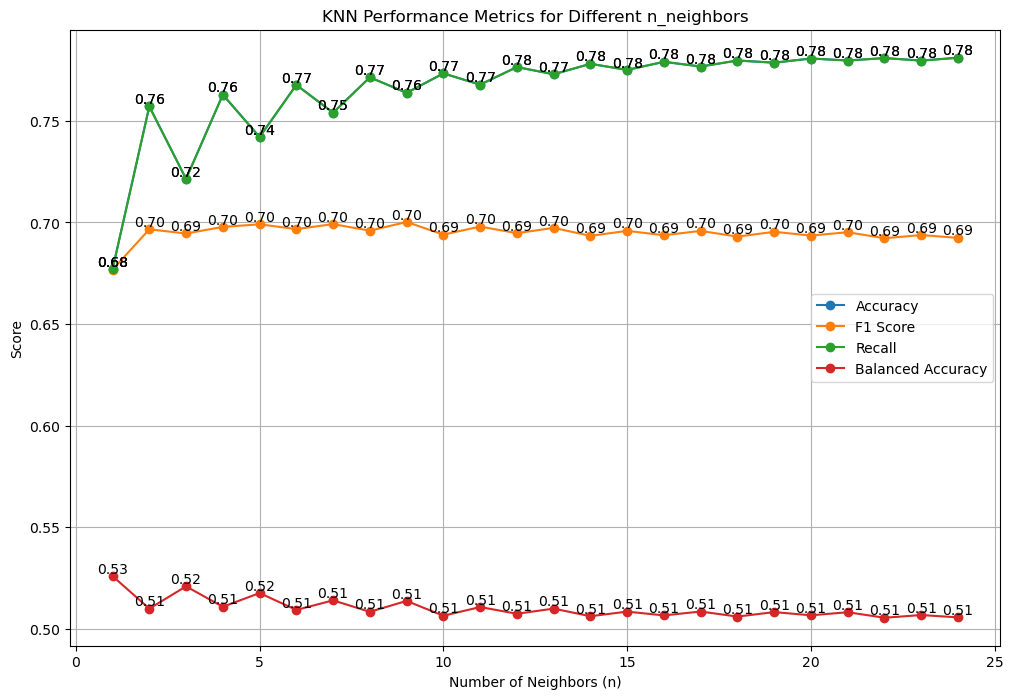

In [196]:
# Dictionary to store results
results = {
    'n_neighbors': [],
    'accuracy': [],
    'f1_score': [],
    'recall': [],
    'balanced_accuracy': []
}

# Loop over the n_neighbors_list
for n in range(1, 25):
    # Instantiate the KNeighborsClassifier with the current n_neighbors
    knn_model = KNeighborsClassifier(n_neighbors=n)
    
    # Cross-validate the model and get the metrics
    metrics = cross_validate_model(knn_model, X_final_train, Y_final_train, splits=10)
    
    # Store the results
    results['n_neighbors'].append(n)
    results['accuracy'].append(metrics['accuracy'])
    results['f1_score'].append(metrics['f1_score'])
    results['recall'].append(metrics['recall'])
    results['balanced_accuracy'].append(metrics['balanced_accuracy'])

# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(12, 8))

plt.plot(results_df['n_neighbors'], results_df['accuracy'], label='Accuracy', marker='o')
plt.plot(results_df['n_neighbors'], results_df['f1_score'], label='F1 Score', marker='o')
plt.plot(results_df['n_neighbors'], results_df['recall'], label='Recall', marker='o')
plt.plot(results_df['n_neighbors'], results_df['balanced_accuracy'], label='Balanced Accuracy', marker='o')

# Annotate the points with the exact values
for i in range(len(results_df)):
    plt.text(results_df['n_neighbors'][i], results_df['accuracy'][i], f"{results_df['accuracy'][i]:.2f}", ha='center', va='bottom')
    plt.text(results_df['n_neighbors'][i], results_df['f1_score'][i], f"{results_df['f1_score'][i]:.2f}", ha='center', va='bottom')
    plt.text(results_df['n_neighbors'][i], results_df['recall'][i], f"{results_df['recall'][i]:.2f}", ha='center', va='bottom')
    plt.text(results_df['n_neighbors'][i], results_df['balanced_accuracy'][i], f"{results_df['balanced_accuracy'][i]:.2f}", ha='center', va='bottom')

plt.xlabel('Number of Neighbors (n)')
plt.ylabel('Score')
plt.title('KNN Performance Metrics for Different n_neighbors')
plt.legend()
plt.grid(True)
plt.show()

DecisionTreeClassifier

<Figure size 1500x1000 with 0 Axes>

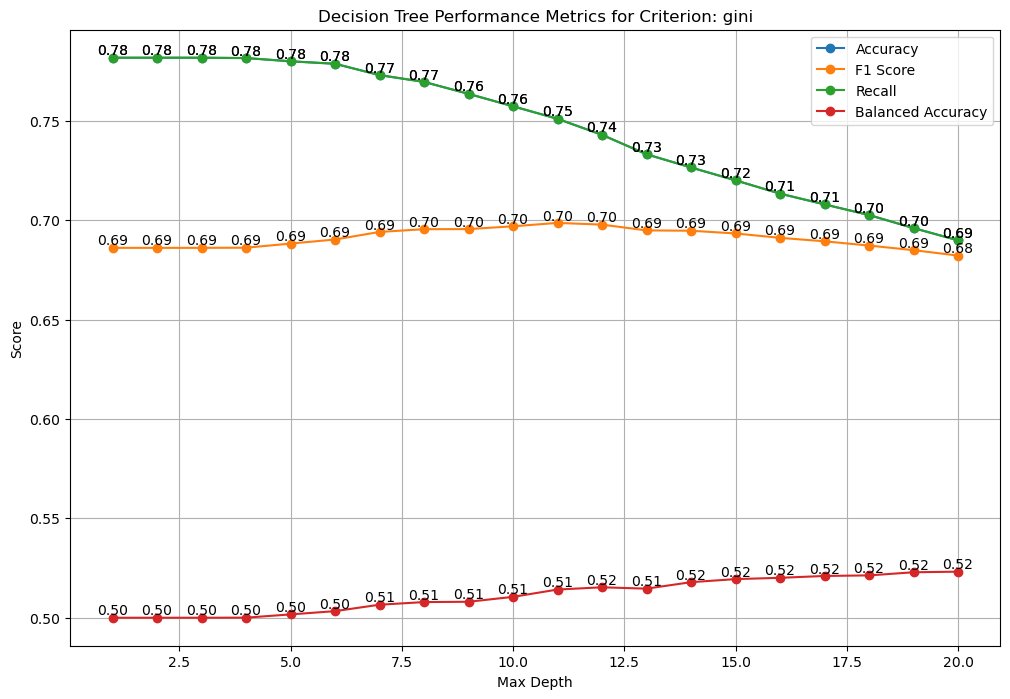

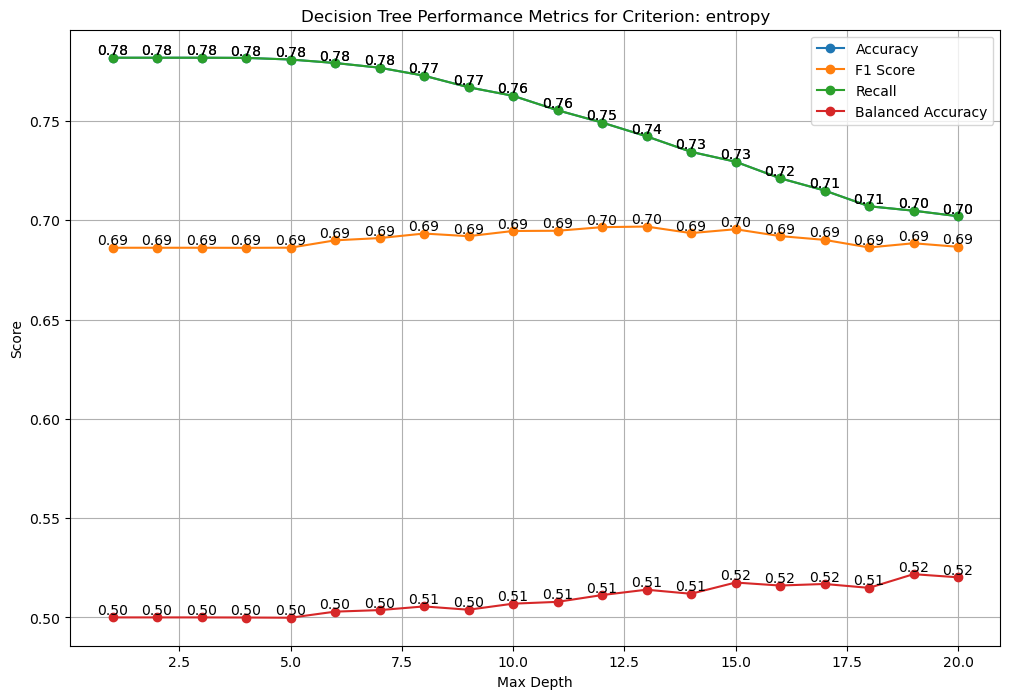

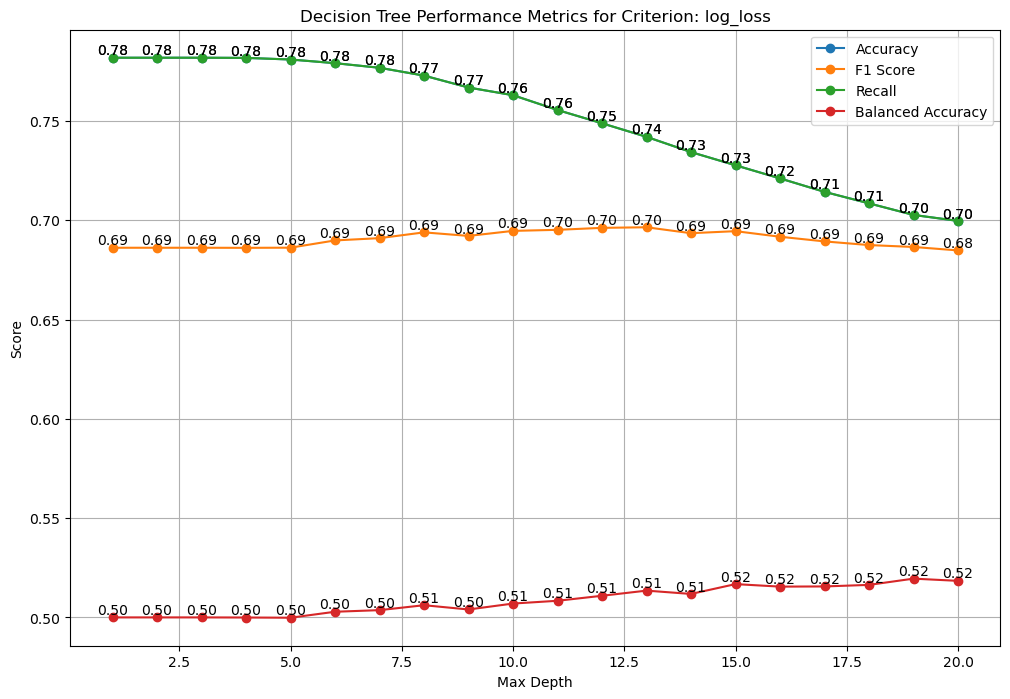

In [195]:
# List of criteria to test
criteria = ["gini", "entropy", "log_loss"]

# Dictionary to store results for each criterion
results = {criterion: {'max_depth': [], 'accuracy': [], 'f1_score': [], 'recall': [], 'balanced_accuracy': []} for criterion in criteria}

# Loop over each criterion and max_depth from 1 to 10
for criterion in criteria:
    for depth in range(1, 21):
        # Instantiate the DecisionTreeClassifier with the current criterion and max_depth
        dt_model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=depth)
        
        # Cross-validate the model and get the metrics
        metrics = cross_validate_model(dt_model, X_final_train, Y_final_train, 10)
        
        # Store the results
        results[criterion]['max_depth'].append(depth)
        results[criterion]['accuracy'].append(metrics['accuracy'])
        results[criterion]['f1_score'].append(metrics['f1_score'])
        results[criterion]['recall'].append(metrics['recall'])
        results[criterion]['balanced_accuracy'].append(metrics['balanced_accuracy'])

# Plot the results for each criterion
plt.figure(figsize=(15, 10))

# Plot the results for each criterion
for criterion in criteria:
    results_df = pd.DataFrame(results[criterion])
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(results_df['max_depth'], results_df['accuracy'], label='Accuracy', marker='o')
    plt.plot(results_df['max_depth'], results_df['f1_score'], label='F1 Score', marker='o')
    plt.plot(results_df['max_depth'], results_df['recall'], label='Recall', marker='o')
    plt.plot(results_df['max_depth'], results_df['balanced_accuracy'], label='Balanced Accuracy', marker='o')

    # Annotate the points with the exact values
    for i in range(len(results_df)):
        plt.text(results_df['max_depth'][i], results_df['accuracy'][i], f"{results_df['accuracy'][i]:.2f}", ha='center', va='bottom')
        plt.text(results_df['max_depth'][i], results_df['f1_score'][i], f"{results_df['f1_score'][i]:.2f}", ha='center', va='bottom')
        plt.text(results_df['max_depth'][i], results_df['recall'][i], f"{results_df['recall'][i]:.2f}", ha='center', va='bottom')
        plt.text(results_df['max_depth'][i], results_df['balanced_accuracy'][i], f"{results_df['balanced_accuracy'][i]:.2f}", ha='center', va='bottom')

    plt.xlabel('Max Depth')
    plt.ylabel('Score')
    plt.title(f'Decision Tree Performance Metrics for Criterion: {criterion}')
    plt.legend()
    plt.grid(True)
    plt.show()

SVM

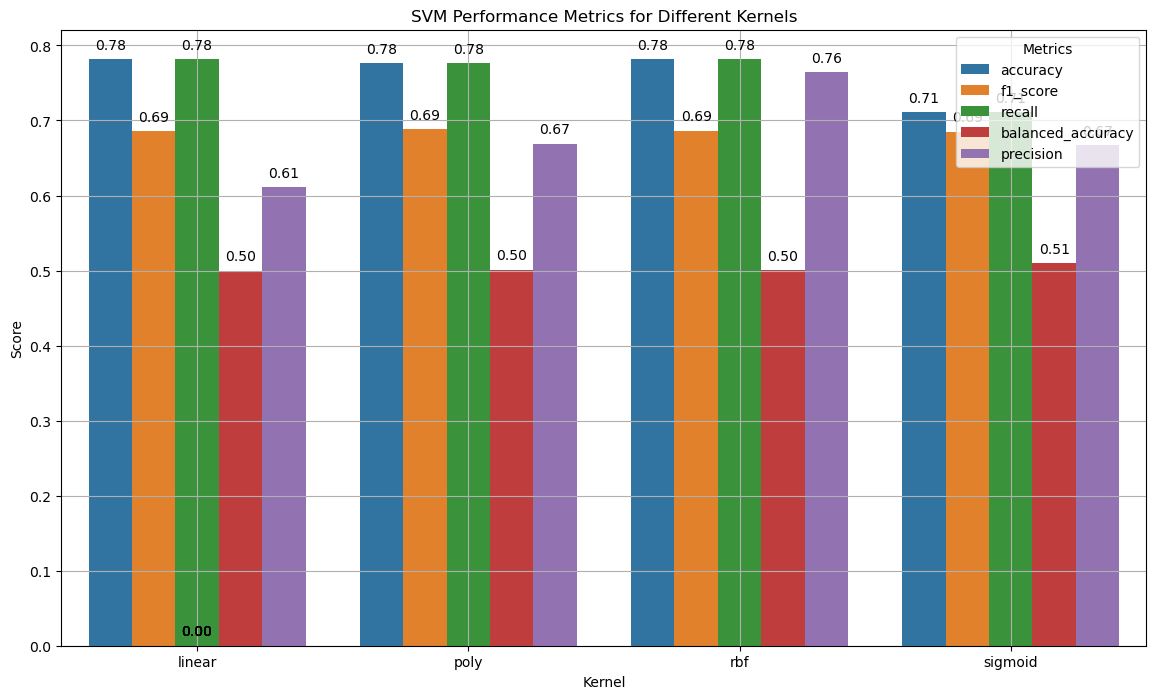

In [212]:
# List of kernels to test
kernels = ["linear", "poly", "rbf", "sigmoid"]

# Dictionary to store results for each kernel
results = {
    'kernel': [],
    'metric': [],
    'value': []
}

# Loop over each kernel
for kernel in kernels:
    # Instantiate the SVC with the current kernel
    svm_model = svm.SVC(kernel=kernel)
    
    # Cross-validate the model and get the metrics
    metrics = cross_validate_model(svm_model, X_final_train, Y_final_train, splits=2)
    
    # Store the results
    for metric, value in metrics.items():
        results['kernel'].append(kernel)
        results['metric'].append(metric)
        results['value'].append(value)

# Convert results to a DataFrame for easy manipulation
results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='kernel', y='value', hue='metric')

# Add labels and title
plt.xlabel('Kernel')
plt.ylabel('Score')
plt.title('SVM Performance Metrics for Different Kernels')
plt.legend(title='Metrics')
plt.grid(True)

# Annotate bars with their values
for p in plt.gca().patches:
    plt.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()